### **Import Libraries**

In [2]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig, TrainingArguments, Trainer
import torch
import time
import pandas as pd
import numpy as np
import string
from nltk.corpus import stopwords
import pandas as pd 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from sklearn.pipeline import Pipeline
import evaluate

import warnings
warnings.filterwarnings('ignore')

### **Import Dataset**

In [4]:
# Importing the Conversation dataset
df = pd.read_csv('Conversation.csv')

In [5]:
# Now df will have columns named 'question' and 'answer'
df.head()

,Unnamed: 0,question,answer
0,0,"hi, how are you doing?",i'm fine. how about yourself?
1,1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.
2,2,i'm pretty good. thanks for asking.,no problem. so how have you been?
3,3,no problem. so how have you been?,i've been great. what about you?
4,4,i've been great. what about you?,i've been good. i'm in school right now.


### **Data Cleaning**

In [7]:
# getting columns list 
df.columns

Index(['Unnamed: 0', 'question', 'answer'], dtype='object')

In [8]:
# Drop unneccessary columns
df.drop(columns=['Unnamed: 0'], inplace=True)

### **Exploratory Data Analysis**

In [10]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

#### Basic Exploration:

* Check the data types of columns.
* Get an overview of the dataset's shape (number of rows and columns).
* Check for any missing values.

In [12]:
print("\nData types of columns:")
print(df.dtypes)
print("\nShape of the dataset:")
print(df.shape)
print("\nMissing values:")
print(df.isnull().sum())


Data types of columns:
question    object
answer      object
dtype: object

Shape of the dataset:
(3725, 2)

Missing values:
question    0
answer      0
dtype: int64


#### Text Analysis:

* Analyze the length distribution of questions and answers.
* Check for any unusual characters or patterns in the text.
* Explore the most common words or phrases in questions and answers (word frequency analysis).

In [14]:
# Length distribution of questions and answers
df['question_length'] = df['question'].apply(len)
df['answer_length'] = df['answer'].apply(len)

#### Visualization:

* Create visualizations to better understand the data distribution (e.g., histograms, word clouds).
* Plot the distribution of question and answer lengths.
* Visualize word frequency using bar plots or word clouds.

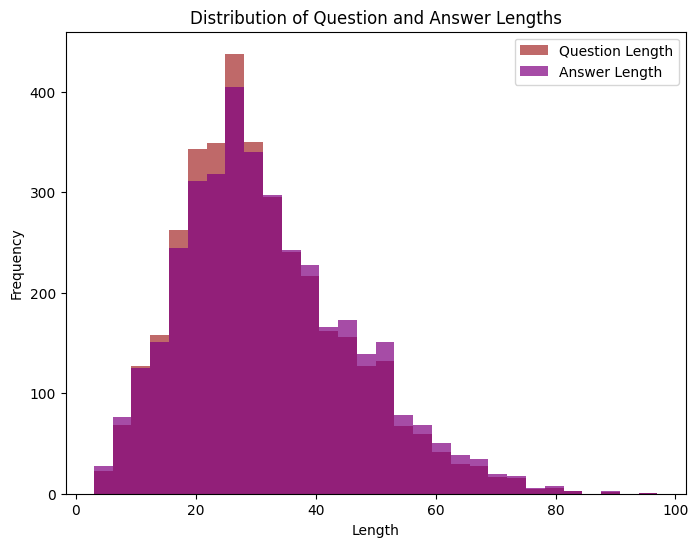

In [16]:
# Visualization
plt.figure(figsize=(8, 6))
plt.hist(df['question_length'], bins=30, alpha=0.7, color='brown', label='Question Length')
plt.hist(df['answer_length'], bins=30, alpha=0.7, color='purple', label='Answer Length')
plt.title('Distribution of Question and Answer Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

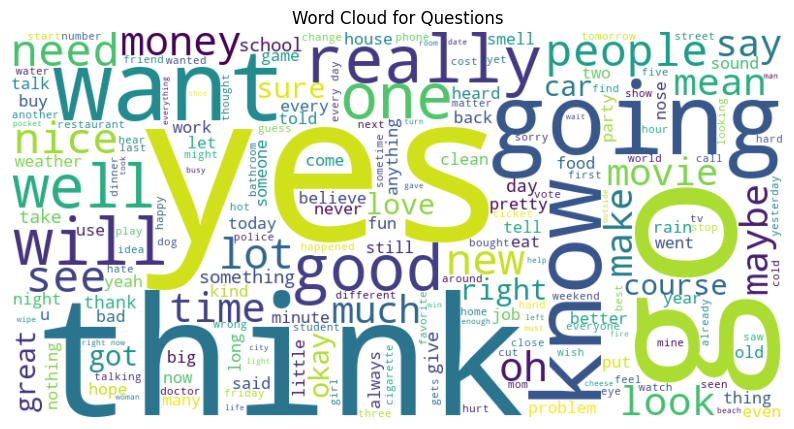

In [17]:
# Word cloud for questions
question_text = ' '.join(df['question'])
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(question_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Questions')
plt.axis('off')
plt.show()

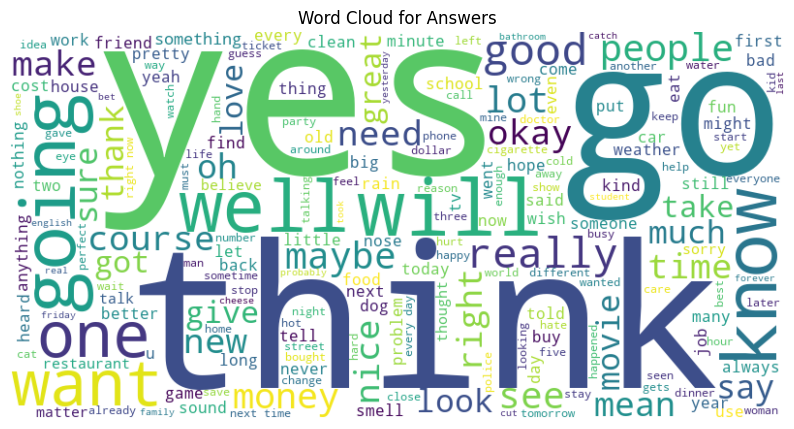

In [18]:
# Word cloud for answers
answer_text = ' '.join(df['answer'])
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(answer_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Answers')
plt.axis('off')
plt.show()

In [19]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob

#### Topic Modeling:

* Use techniques like Latent Dirichlet Allocation (LDA) to identify underlying topics in the questions and answers.
* Cluster similar questions and answers based on topic distributions.

In [21]:
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(df['question'])
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)
# Display the top words for each topic
for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx}:", ", ".join([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]]))


Topic 0: think, really, time, maybe, mean, ve, ll, better, let, doing
Topic 1: like, yes, want, didn, day, right, say, does, just, going
Topic 2: good, know, don, need, sure, course, great, new, haven, won
Topic 3: did, people, lot, school, don, today, really, yes, oh, think
Topic 4: ll, going, okay, nice, money, got, make, car, think, big


#### Language Complexity:

* Measure the complexity of language used in questions and answers (e.g., average word length, vocabulary richness).
* Explore readability scores or linguistic features.

In [23]:
df['question_word_count'] = df['question'].apply(lambda x: len(x.split()))
df['answer_word_count'] = df['answer'].apply(lambda x: len(x.split()))

# Analyze language complexity
avg_question_word_length = df['question'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split())).mean()
avg_answer_word_length = df['answer'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split())).mean()

print("\nAverage word length in questions:", avg_question_word_length)
print("Average word length in answers:", avg_answer_word_length)


Average word length in questions: 4.166798629795689
Average word length in answers: 4.176433319293585


### **Data Preprocessing**

#### Data Augmentation (UPSampling)

In [26]:
columns = ["question", "answer"]
# Define the new dialogue data
new_dialogue_data = [
    ["Hi", "Hello"],
    ["How are you?", "I'm good, thanks for asking. How about you?"],
    ["I'm doing well too.", "That's great to hear. What have you been up to lately?"],
    ["Not much, just working and spending time with family.", "That sounds nice. Have you watched any good movies recently?"],
    ["Yeah, I saw a really good one last weekend.", "It was a thriller, right? I heard good things about it."],
    ["Yes, it was.", "Do you want to watch it together sometime?"],
    ["Sure, that sounds like a plan.", "Awesome! Let's plan it for this weekend."],
    ["Sounds good to me.", "Alright then, it's a plan. What time works for you?"],
    ["How about Saturday evening?", "Perfect! Saturday evening it is. I'll book the tickets."],
    ["Great! Looking forward to it.", "Me too. It'll be fun."]
]
new_df = pd.DataFrame(new_dialogue_data, columns=columns)

# Concatenate the new DataFrame with the existing DataFrame
df = pd.concat([df, new_df], ignore_index=True)

# Print the updated DataFrame
df.head()

,question,answer,question_length,answer_length,question_word_count,answer_word_count
0,"hi, how are you doing?",i'm fine. how about yourself?,22.0,29.0,5.0,5.0
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.,29.0,35.0,5.0,6.0
2,i'm pretty good. thanks for asking.,no problem. so how have you been?,35.0,33.0,6.0,7.0
3,no problem. so how have you been?,i've been great. what about you?,33.0,32.0,7.0,6.0
4,i've been great. what about you?,i've been good. i'm in school right now.,32.0,40.0,6.0,8.0


#### Preprocessing
* Lowercase
* Tokenization
* Stop words removal
* Lemmization

In [28]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')

# Function for preprocessing text
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
#     tokens = word_tokenize(text)
#     tokens = [word for word in tokens if word.isalnum()]
#     preprocessed_text = ' '.join(tokens)
    
    return text

# Apply preprocessing to question and answer columns
preprocessed_df = df.copy()
preprocessed_df['question'] = preprocessed_df['question'].apply(preprocess_text)
preprocessed_df['answer'] = preprocessed_df['answer'].apply(preprocess_text)

# Print the preprocessed DataFrame
preprocessed_df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sushant\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,question,answer,question_length,answer_length,question_word_count,answer_word_count
0,"hi, how are you doing?",i'm fine. how about yourself?,22.0,29.0,5.0,5.0
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.,29.0,35.0,5.0,6.0
2,i'm pretty good. thanks for asking.,no problem. so how have you been?,35.0,33.0,6.0,7.0
3,no problem. so how have you been?,i've been great. what about you?,33.0,32.0,7.0,6.0
4,i've been great. what about you?,i've been good. i'm in school right now.,32.0,40.0,6.0,8.0


### **Classical ML ChatBot** 

In [30]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(preprocessed_df['question'], preprocessed_df['answer'], test_size=0.2, random_state=42, shuffle=True)

#### Model Pipline and training

In [32]:
Pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', RandomForestClassifier())
])

Pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('classifier', RandomForestClassifier())])

In [33]:
Pipe.predict(['where are you going'])[0]

'we went to a nice restaurant.'

#### Model Evaluation

In [35]:
# Predicting text using the pipeline on the test set
predicted_text = Pipe.predict(X_test)

# Creating a DataFrame to compare the first 10 results
comparison_df = pd.DataFrame({'Real Question ': X_test[:10],'Real Generated Text': y_test[:10], 'Predicted Text': predicted_text[:10]})
comparison_df.head(10)

,Real Question,Real Generated Text,Predicted Text
3253,how are you doing that?,i started shopping at the dollar store.,i was writing a letter.
3190,"the pants are fine, but the pocket has a huge ...",you shouldn't carry your keys and pens in your...,"yes, it has lots of rooms and lots of space."
2194,uh-oh. that means that she's fat and ugly.,she's cute.,men singers don't have to look good.
3303,that's great. we won't have neighbors on both ...,no pets are allowed.,people take care of their lawns.
642,"i really wanted you to come, but i understand.","yeah, maybe next time.",i have things to do.
3214,that's a good deal.,and a one-pound tub of soft butter was the sam...,"yes, even though some of the potatoes had eyes."
184,she's one of the prettiest girls at the school.,what does she look like?,maybe we should learn some good jokes.
3515,"no, that's not the problem.",maybe it will go away in a little while.,someone cut the tires.
3185,why not?,i didn't want to pay for the holes.,i don't know. maybe i'm not rich enough.
2206,eight o'clock.,that sounds great.,"oh, well, how many people has she given invite..."


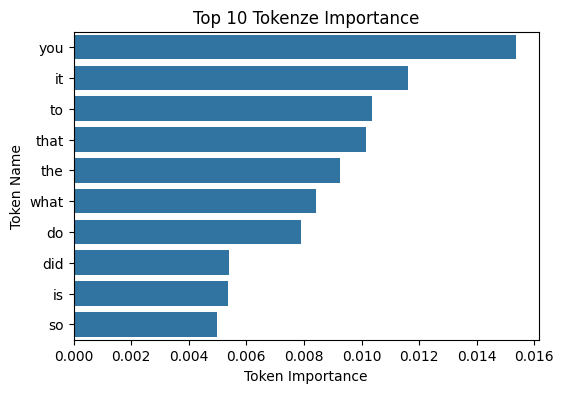

In [36]:
import seaborn as sns

# Visualize Feature Importance
if isinstance(Pipe.named_steps['classifier'], RandomForestClassifier):
    feature_importances = Pipe.named_steps['classifier'].feature_importances_
    feature_names = Pipe.named_steps['tfidf'].get_feature_names_out()

    # Sort feature importances
    sorted_indices = feature_importances.argsort()[::-1]
    top_feature_importances = feature_importances[sorted_indices][:10]
    top_feature_names = np.array(feature_names)[sorted_indices][:10]

    plt.figure(figsize=(6, 4))
    sns.barplot(x=top_feature_importances, y=top_feature_names)
    plt.xlabel('Token Importance')
    plt.ylabel('Token Name')
    plt.title('Top 10 Tokenze Importance')
    plt.show()


#### Chat with you ChatBot :D

### **Encoder - Decoder Model with Attention and LSTMs Chatbot from scratch**

In [39]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Attention, Concatenate

#### Seq2Seq Text Preprocessing

In [41]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import unicodedata


nltk.download('punkt')

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

# Function for preprocessing text
def preprocess_text(text):
    # Convert text to lowercase
    text = unicode_to_ascii(text.lower().strip())
    text = re.sub("(\\W)"," ",text) 
    text = re.sub('\S*\d\S*\s*','', text)
    text =  "<sos> " +  text + "<eos>"
    return text

# Apply preprocessing to question and answer columns
preprocessed_df = df.copy()
preprocessed_df['question'] = preprocessed_df['question'].apply(preprocess_text)
preprocessed_df['answer'] = preprocessed_df['answer'].apply(preprocess_text)

# Print the preprocessed DataFrame
preprocessed_df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sushant\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,question,answer,question_length,answer_length,question_word_count,answer_word_count
0,<sos> hi how are you doing <eos>,<sos> i m fine how about yourself <eos>,22.0,29.0,5.0,5.0
1,<sos> i m fine how about yourself <eos>,<sos> i m pretty good thanks for asking <eos>,29.0,35.0,5.0,6.0
2,<sos> i m pretty good thanks for asking <eos>,<sos> no problem so how have you been <eos>,35.0,33.0,6.0,7.0
3,<sos> no problem so how have you been <eos>,<sos> i ve been great what about you <eos>,33.0,32.0,7.0,6.0
4,<sos> i ve been great what about you <eos>,<sos> i ve been good i m in school right now ...,32.0,40.0,6.0,8.0


#### Tokenizer

In [43]:
# Preprocessing the data
questions = preprocessed_df['question'].values.tolist()
answers = preprocessed_df['answer'].values.tolist()

# Tokenizing the data
tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(np.concatenate((questions, answers), axis=0))

vocab_size = len(tokenizer.word_index) + 1

# Convert text to sequences
question_seqs = tokenizer.texts_to_sequences(questions)
answer_seqs = tokenizer.texts_to_sequences(answers)

# Padding sequences for equal length
# Pad sequences for equal length
max_len_question = max(len(seq) for seq in question_seqs)
max_len_answer = max(len(seq) for seq in answer_seqs)
max_len = max(max_len_question, max_len_answer)
print(max(max_len_question, max_len_answer))
# Pad sequences separately for questions and answers
question_seqs = pad_sequences(question_seqs, maxlen=max_len, padding='post')
answer_seqs = pad_sequences(answer_seqs, maxlen=max_len, padding='post')

22


In [44]:
tokenizer.texts_to_sequences("<sos>")

[[], [9], [490], [9], []]

In [45]:
tokenizer.word_index["<sos>"]

1

#### Model Architecture

In [47]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Attention, Concatenate, Dropout

# Define the model architecture
latent_dim = 256  # Dimensionality of the encoding space

# Encoder
encoder_inputs = Input(shape=(max_len,))
encoder_embedding = Embedding(vocab_size, latent_dim, input_shape=(max_len,))
encoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.1, recurrent_dropout=0.1)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding(encoder_inputs))
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_len-1,))
decoder_embedding = Embedding(vocab_size, latent_dim, input_shape=(max_len-1,))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.1, recurrent_dropout=0.1)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding(decoder_inputs), initial_state=encoder_states)

# Attention mechanism
attention_layer = Attention()
attention_output = attention_layer([decoder_outputs, encoder_outputs])

# Concatenate attention output and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1)([decoder_outputs, attention_output])

# Add dropout layer for regularization
decoder_concat_input = Dropout(0.1)(decoder_concat_input)

# Output layer
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat_input)

#### Model Training

In [49]:
# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# Print model summary
model.summary()

# Train the model
model.fit([question_seqs, answer_seqs[:, :-1]], answer_seqs[:, 1:],
          batch_size=64,
          epochs=32,
          validation_split=0.2)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 22)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 21)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 22, 256)   │    620,800 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 21, 256)   │    620,800 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 22, 256), │    525,312 │ embedding[0][0]   │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 21, 256), │    525,312 │ embedding_1[0][0… │
│                     │ (None, 256),      │            │ lstm[0][1],       │
│                     │ (None, 256)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 21, 256)   │          0 │ lstm_1[0][0],     │
│ (Attention)         │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 21, 512)   │          0 │ lstm_1[0][0],     │
│ (Concatenate)       │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 21, 512)   │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 21, 2425)  │  1,244,025 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,536,249 (13.49 MB)

 Trainable params: 3,536,249 (13.49 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/32
47/47 ━━━━━━━━━━━━━━━━━━━━ 45s 708ms/step - loss: 4.2722 - val_loss: 2.3142
Epoch 2/32
47/47 ━━━━━━━━━━━━━━━━━━━━ 38s 652ms/step - loss: 2.0213 - val_loss: 2.2542
Epoch 3/32
47/47 ━━━━━━━━━━━━━━━━━━━━ 41s 650ms/step - loss: 1.9631 - val_loss: 2.2386
Epoch 4/32
47/47 ━━━━━━━━━━━━━━━━━━━━ 32s 669ms/step - loss: 1.8870 - val_loss: 2.2008
Epoch 5/32
47/47 ━━━━━━━━━━━━━━━━━━━━ 34s 742ms/step - loss: 1.8362 - val_loss: 2.1671
Epoch 6/32
47/47 ━━━━━━━━━━━━━━━━━━━━ 33s 706ms/step - loss: 1.7658 - val_loss: 2.1418
Epoch 7/32
47/47 ━━━━━━━━━━━━━━━━━━━━ 34s 714ms/step - loss: 1.7182 - val_loss: 2.1176
Epoch 8/32
47/47 ━━━━━━━━━━━━━━━━━━━━ 31s 673ms/step - loss: 1.6495 - val_loss: 2.0907
Epoch 9/32
47/47 ━━━━━━━━━━━━━━━━━━━━ 33s 710ms/step - loss: 1.5888 - val_loss: 2.0841
Epoch 10/32
47/47 ━━━━━━━━━━━━━━━━━━━━ 38s 643ms/step - loss: 1.5553 - val_loss: 2.0825
Epoch 11/32
47/47 ━━━━━━━━━━━━━━━━━━━━ 42s 655ms/step - loss: 1.5085 - val_loss: 2.0814
Epoch 12/32
47/47 ━━━━━━━━━━━━━━━━━━━━ 33

#### Model Prediction Evaluation

In [51]:
# Function to generate a response given a input sentence
def generate_response(input_text):
    # Tokenize the input text
    input_sequence = tokenizer.texts_to_sequences([input_text])
    # Pad the input sequence
    input_sequence = pad_sequences(input_sequence, maxlen=max_len, padding='post')
    
    # Initialize the decoder input sequence with start token
    decoder_input_sequence = np.zeros((1, max_len-1))
    decoder_input_sequence[0, 0] = tokenizer.word_index['<sos>']
    
    # Generate response using the trained model
    for i in range(max_len - 1):
        predictions = model.predict([input_sequence, decoder_input_sequence])
        predicted_id = np.argmax(predictions[0, i, :])
        if predicted_id == tokenizer.word_index['<eos>']:
            break
        decoder_input_sequence[0, i+1] = predicted_id
    
    # Convert output sequence to text
    output_text = ''
    for token_index in decoder_input_sequence[0]:
        if token_index == tokenizer.word_index['<eos>'] or token_index == 0:
            break
        output_text += tokenizer.index_word[token_index] + ' '
    
    return output_text.strip()

# Test the function with input "how are you"
input_text = "how do you do"
response = generate_response(input_text)
print("Response:", response[5:])


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 942ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Response:  i m not going to pcc


### **Fine-Tuning a Generative-AI LLM ChatBot**

In [53]:
model_name='google/flan-t5-small'

original_model = AutoModelForSeq2SeqLM.from_pretrained(model_name, torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(model_name)

It is possible to pull out the number of model parameters and find out how many of them are trainable. The following function can be used to do that, at this stage, you do not need to go into details of it.

In [55]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

print(print_number_of_trainable_model_parameters(original_model))

trainable model parameters: 76961152
all model parameters: 76961152
percentage of trainable model parameters: 100.00%


#### Test the Model with Zero Shot Inferencing
Test the model with the zero shot inferencing. You can see that the model struggles to summarize the dialogue compared to the baseline summary, but it does pull out some important information from the text which indicates the model can be fine-tuned to the task at hand.

In [57]:
index = 0

question = df['question'][index]
answer = df['answer'][index]

prompt = f"""
Answere the following question.

{question}

Answere:
"""

inputs = tokenizer(prompt, return_tensors='pt')
output = tokenizer.decode(
    original_model.generate(
        inputs["input_ids"], 
        max_new_tokens=22,
    )[0], 
    skip_special_tokens=True
)

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{prompt}')
print(dash_line)
print(f'BASELINE HUMAN ANSWER:\n{answer}\n')
print(dash_line)
print(f'MODEL GENERATION - ZERO SHOT:\n{output}')

---------------------------------------------------------------------------------------------------
INPUT PROMPT:

Answere the following question.

hi, how are you doing?

Answere:

---------------------------------------------------------------------------------------------------
BASELINE HUMAN ANSWER:
i'm fine. how about yourself?

---------------------------------------------------------------------------------------------------
MODEL GENERATION - ZERO SHOT:
i'm a sailor


#### Preprocess the Question-Answer Dataset


In [59]:
def tokenize_function(row):
    start_prompt = 'Answer the following question.\n\n'
    end_prompt = '\n\nAnswer: '
    
    # Convert the question to a string if it's a list
    question = ' '.join(row["question"]) if isinstance(row["question"], list) else row["question"]
    
    prompt = start_prompt + question + end_prompt
    row['input_ids'] = tokenizer(prompt, padding="max_length", truncation=True, return_tensors="pt").input_ids[0]
    
    # Assuming "answer" column is already a string, no need for conversion
    row['labels'] = tokenizer(row["answer"], padding="max_length", truncation=True, return_tensors="pt").input_ids[0]
    
    return row


# Tokenize the DataFrame
tokenized_df = df.apply(tokenize_function, axis=1)

# Convert tensors to lists
tokenized_df = tokenized_df[:-150]
tokenized_df = tokenized_df.drop(index=708)
tokenized_df['input_ids'] = tokenized_df['input_ids'].apply(lambda x: x.tolist())
tokenized_df['labels'] = tokenized_df['labels'].apply(lambda x: x.tolist())

In [60]:
from datasets import Dataset

# Assuming `tokenized_df` is your pandas DataFrame
dataset = Dataset.from_pandas(tokenized_df)

In [61]:
tokenized_datasets = dataset.map(tokenize_function, batched=True, batch_size=512)
tokenized_datasets = tokenized_datasets.remove_columns(['question', 'answer',])

Map:   0%|          | 0/3584 [00:00<?, ? examples/s]

In [62]:
dataset.shape

(3584, 9)

In [63]:
dataset

Dataset({
    features: ['question', 'answer', 'question_length', 'answer_length', 'question_word_count', 'answer_word_count', 'input_ids', 'labels', '__index_level_0__'],
    num_rows: 3584
})

#### Fine-Tune the Model with the Preprocessed Dataset
Now utilize the built-in Hugging Face Trainer class. Pass the preprocessed dataset with reference to the original model. Other training parameters are found experimentally and there is no need to go into details about those at the moment.

In [65]:
output_dir = f'/kaggle/working/LLM'

training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=1e-5,
    #num_train_epochs=3,       # Increase the number of training epochs to 3
    weight_decay=0.01,
    logging_steps=50,
    #max_steps=1000           # Increase the maximum number of training steps to 1000
)


trainer = Trainer(
    model=original_model,
    args=training_args,
    train_dataset=dataset,
)

In [66]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

# Initialize model and tokenizer
model = T5ForConditionalGeneration.from_pretrained("t5-small")
tokenizer = T5Tokenizer.from_pretrained("t5-small", legacy=False)  # Use the new behavior explicitly

# Sample input for translating English to Hindi
input_text = "Translate English to Hindi: How are you?"

# Tokenize input
input_ids = tokenizer.encode(input_text, return_tensors="pt")

# Forward pass
outputs = model.generate(input_ids)

# Decode the output
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(generated_text)


Translat Translat Translate English to Hindi: How are you?


Create an instance of the `AutoModelForSeq2SeqLM` class for the instruct model:

In [68]:
# instruct_model = AutoModelForSeq2SeqLM.from_pretrained("", torch_dtype=torch.bfloat16)

from transformers import AutoModelForSeq2SeqLM

instruct_model = AutoModelForSeq2SeqLM.from_pretrained(
    "t5-small",
    torch_dtype=torch.bfloat16
)


#### Evaluate the Model Qualitatively (Human Evaluation)
As with many GenAI applications, a qualitative approach where you ask yourself the question "Is my model behaving the way it is supposed to?" is usually a good starting point. In the example below (the same one we started this notebook with), you can see how the fine-tuned model is able to create a reasonable summary of the dialogue compared to the original inability to understand what is being asked of the model.

In [70]:
index = 1

question = df['question'][index]
answer = df['answer'][index]

prompt = f"""
Answere the following question.

{question}

Answere:
"""

input_ids = tokenizer(prompt, return_tensors="pt").input_ids

# Move input_ids tensor to the same device as the model
input_ids = input_ids.to(original_model.device)

# Generate outputs using the original model
original_model_outputs = original_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=22, num_beams=1))
original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)

input_ids = input_ids.to(instruct_model.device)
# Generate outputs using the instruct model
instruct_model_outputs = instruct_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=22, num_beams=1))
instruct_model_text_output = tokenizer.decode(instruct_model_outputs[0], skip_special_tokens=True)

# Print the results
print(dash_line)
print(f'BASELINE HUMAN QUERY:\n{question}')
print(dash_line)
print(f'BASELINE HUMAN ANSWER:\n{answer}')
print(dash_line)
print(f'ORIGINAL MODEL:\n{original_model_text_output}')
print(dash_line)
print(f'INSTRUCT MODEL:\n{instruct_model_text_output}')


---------------------------------------------------------------------------------------------------
BASELINE HUMAN QUERY:
i'm fine. how about yourself?
---------------------------------------------------------------------------------------------------
BASELINE HUMAN ANSWER:
i'm pretty good. thanks for asking.
---------------------------------------------------------------------------------------------------
ORIGINAL MODEL:
i'm fine.
---------------------------------------------------------------------------------------------------
INSTRUCT MODEL:
Answere:


#### Evaluate the Model Quantitatively (with ROUGE Metric)
The `ROUGE metric` helps quantify the validity of summarizations produced by models. It compares summarizations to a "baseline" summary which is usually created by a human. While not perfect, it does indicate the overall increase in summarization effectiveness that we have accomplished by fine-tuning.

In [72]:
rouge = evaluate.load('rouge')

Generate the outputs for the sample of the test dataset (only 5 dialogues and summaries to save time), and save the results.

In [74]:
question = dataset['question'][0:5]
human_baseline_answer = dataset['answer'][0:5]

original_model_answer = []
instruct_model_answer = []

for _, question in enumerate(question):
    prompt = f"""
Complete the following query.

{question}

Summary: """
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids
    input_ids = input_ids.to(original_model.device)

    original_model_outputs = original_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)
    original_model_answer.append(original_model_text_output)
    input_ids = input_ids.to(instruct_model.device)

    instruct_model_outputs = instruct_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    instruct_model_text_output = tokenizer.decode(instruct_model_outputs[0], skip_special_tokens=True)
    instruct_model_answer.append(instruct_model_text_output)
    
zipped_answers = list(zip(human_baseline_answer, original_model_answer, instruct_model_answer))
 
dataframe = pd.DataFrame(zipped_answers, columns = ['human_baseline_summaries', 'original_model_summaries', 'instruct_model_summaries'])
dataframe

,human_baseline_summaries,original_model_summaries,instruct_model_summaries
0,i'm fine. how about yourself?,i'm doing a lot of work.,
1,i'm pretty good. thanks for asking.,I'm fine.,
2,no problem. so how have you been?,I'm a bit of a fan of the sand.,i'm pretty good. thanks for asking.
3,i've been great. what about you?,i have been a snobber for a while.,
4,i've been good. i'm in school right now.,I've been a great fan of you.,


Evaluate the models computing ROUGE metrics. Notice the improvement in the results!



In [76]:
original_model_results = rouge.compute(
    predictions=original_model_answer,
    references=human_baseline_answer[0:len(original_model_answer)],
    use_aggregator=True,
    use_stemmer=True,
)

instruct_model_results = rouge.compute(
    predictions=instruct_model_answer,
    references=human_baseline_answer[0:len(instruct_model_answer)],
    use_aggregator=True,
    use_stemmer=True,
)

print('ORIGINAL MODEL:')
print(original_model_results)
print('INSTRUCT MODEL:')
print(instruct_model_results)

ORIGINAL MODEL:
{'rouge1': 0.2646153846153846, 'rouge2': 0.13636363636363635, 'rougeL': 0.2666666666666667, 'rougeLsum': 0.2646153846153846}
INSTRUCT MODEL:
{'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0, 'rougeLsum': 0.0}


The results show substantial improvement in all ROUGE metrics:

In [78]:
print("Absolute percentage improvement of INSTRUCT MODEL over HUMAN BASELINE")

improvement = (np.array(list(instruct_model_results.values())) - np.array(list(original_model_results.values())))
for key, value in zip(instruct_model_results.keys(), improvement):
    print(f'{key}: {value*100:.2f}%')

Absolute percentage improvement of INSTRUCT MODEL over HUMAN BASELINE
rouge1: -26.46%
rouge2: -13.64%
rougeL: -26.67%
rougeLsum: -26.46%
